<a href="https://colab.research.google.com/github/EliabeBastosDias/analise-de-vinhos-portugueses/blob/main/TCC1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importações de bibliotecas

In [ ]:
# Bibliotecas padrão
import os
import shutil

# Manipulação de dados
import pandas as pd

# Conexão com google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Conexão com a base de dados

In [ ]:
# Configura o caminho para o dataset no Drive

dataset_path = '/content/drive/MyDrive/TCC/Data'
print(os.listdir())

['.config', 'drive', 'sample_data']


In [ ]:
# Transforma csv de anotações em um dataframe

csv_path = f"{dataset_path}/ObjectDetection.xlsx"
annotations = pd.read_excel(csv_path)
annotations['fname'] = annotations['fname'].apply(lambda x: os.path.join(dataset_path, os.path.basename(x)))



display(annotations.head())

,fname,structure,h_min,w_min,h_max,w_max
0,/content/drive/MyDrive/TCC/Data/168.png,thalami,178,171,244,261
1,/content/drive/MyDrive/TCC/Data/168.png,nasal bone,96,308,111,349
2,/content/drive/MyDrive/TCC/Data/168.png,palate,133,300,205,408
3,/content/drive/MyDrive/TCC/Data/168.png,nasal skin,86,324,95,349
4,/content/drive/MyDrive/TCC/Data/168.png,nasal tip,79,345,89,376


# Estatística descritiva

In [ ]:
annotations['name'] = annotations['structure'].astype(str).str.strip()
number_of_structures = annotations['name'].nunique()

print(f"Quantidade de imagens distintas: {annotations['fname'].nunique()}")
print(f"Quantidade de anotações: {len(annotations)}")
print("")
print(f"Quantidade de estruturas: {annotations['name'].nunique()}")
print(f"Estruturas: {[item for item in list(annotations['name'].unique())]}")

Quantidade de imagens distintas: 1131
Quantidade de anotações: 9433

Quantidade de estruturas: 9
Estruturas: ['thalami', 'nasal bone', 'palate', 'nasal skin', 'nasal tip', 'midbrain', 'NT', 'IT', 'CM']


# Densenet 121

## Pré Processamento

In [ ]:
mapping = {
    "thalami": 0,
    "nasal bone": 8,
    "palate": 1,
    "nasal skin": 2,
    "nasal tip": 3,
    "midbrain": 4,
    "NT": 5,
    "IT": 6,
    "CM": 7
}

annotations["code"] = annotations["name"].map(mapping)

In [ ]:
def filter_annotations(structure):
  return annotations[annotations['name'].isin([structure])].copy()

thalami = filter_annotations("thalami")
palate = filter_annotations("palate")
nasal_skin = filter_annotations("nasal skin")
nasal_tip = filter_annotations("nasal tip")
midbrain = filter_annotations("midbrain")
nuchal_translucency = filter_annotations("NT")
intracranial_translucency = filter_annotations("IT")
cisterna_magna = filter_annotations("CM")

structures = {
  "thamali": {
      "raw": thalami,
      "training": None,
      "validation": None,
      "weights": None,
      "densenet": None
  },
  "palate": {
      "raw": palate,
      "training": None,
      "validation": None,
      "weights": None,
      "densenet": None,
      "loader": None,
  },
  "nasal_skin": {
      "raw": nasal_skin,
      "training": None,
      "validation": None,
      "weights": None,
      "densenet": None,
      "loader": None,
  },
  "nasal_tip": {
      "raw": nasal_tip,
      "training": None,
      "validation": None,
      "weights": None,
      "densenet": None,
      "loader": None,
  },
  "midbrain": {
      "raw": midbrain,
      "training": None,
      "validation": None,
      "weights": None,
      "densenet": None,
      "loader": None,
  },
  "nuchal_transluceny": {
      "raw": nuchal_translucency,
      "training": None,
      "validation": None,
      "weights": None,
      "densenet": None,
      "loader": None,
  },
  "intracranial_translucency": {
      "raw": intracranial_translucency,
      "training": None,
      "validation": None,
      "weights": None,
      "densenet": None,
      "loader": None,
  },
  "cisterna_magna": {
      "raw": cisterna_magna,
      "training": None,
      "validation": None,
      "weights": None,
      "densenet": None,
      "loader": None,
  }
}

print(f"""
  thalami: {len(thalami)}
  palate: {len(palate)}
  nasal_skin: {len(nasal_skin)}
  nasal_tip: {len(nasal_tip)}
  midbrain: {len(midbrain)}
  nuchal_translucency: {len(nuchal_translucency)}
  intracranial_translucency: {len(intracranial_translucency)}
  cisterna_magna: {len(cisterna_magna)}
""")


  thalami: 1122
  palate: 1031
  nasal_skin: 840
  nasal_tip: 989
  midbrain: 1119
  nuchal_translucency: 1110
  intracranial_translucency: 1110
  cisterna_magna: 1097



In [ ]:
for name, structure in structures.items():
  train_set, validation_set = train_test_split(structure["raw"], test_size=0.2, random_state=42)
  structures[name]["training"] = train_set
  structures[name]["validation"] = validation_set

  print(name)
  print("Train size:", len(train_set))
  print("Validation size:", len(validation_set))
  print("")

thamali
Train size: 897
Validation size: 225

palate
Train size: 824
Validation size: 207

nasal_skin
Train size: 672
Validation size: 168

nasal_tip
Train size: 791
Validation size: 198

midbrain
Train size: 895
Validation size: 224

nuchal_transluceny
Train size: 888
Validation size: 222

intracranial_translucency
Train size: 888
Validation size: 222

cisterna_magna
Train size: 877
Validation size: 220



In [ ]:
class FetalImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['fname']).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = row['code']
        return img, label

## Treinamento

In [ ]:
for name, structure in structures.items():
    if structure["training"].empty:
        print(f"{name}: Sem dados para treino. Pulando...")
        structure["weights"] = None # Handle case with no training data
        continue

    # Get the unique code for this structure from its training data.
    # Assuming each 'structure' DataFrame has only one unique 'code'.
    unique_codes_in_training = structure["training"]['code'].unique()
    if len(unique_codes_in_training) != 1:
        print(f"Error: Expected exactly one unique code for structure '{name}', but found {len(unique_codes_in_training)}: {unique_codes_in_training}")
        # For a quick fix, let's proceed with the first unique code, but note the warning.
        current_code = unique_codes_in_training[0]
    else:
        current_code = unique_codes_in_training[0]

    # Create a weight tensor of size 'number_of_structures' (which is 9)
    # Initialize all weights to 0.0
    class_weights_tensor_for_structure = torch.zeros(number_of_structures, dtype=torch.float).to(device)

    # Set the weight for the current structure's code to 1.0.
    # This aligns with the previous normalization `class_weights / class_weights.max()` effectively yielding 1.0.
    class_weights_tensor_for_structure[current_code] = 1.0

    structure["weights"] = class_weights_tensor_for_structure
    print(f"Pesos para {name}:", structure["weights"])

Pesos para thamali: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
Pesos para palate: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
Pesos para nasal_skin: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')
Pesos para nasal_tip: tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0')
Pesos para midbrain: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0')
Pesos para nuchal_transluceny: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')
Pesos para intracranial_translucency: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0')
Pesos para cisterna_magna: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0')


In [ ]:
training_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ToTensor(),
])

validations_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

for name, structure in structures.items():
  training_dataset = FetalImageDataset(structure["training"], training_transforms)
  validation_dataset   = FetalImageDataset(structure["validation"], validations_transforms)
  loader = {
      "training": DataLoader(training_dataset, batch_size=32, shuffle=True, num_workers=2),
      "validation": DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=2)
  }
  structures[name]["loader"] = loader

In [ ]:
for name, structure in structures.items():
  model = models.densenet121(weights="DEFAULT")
  model.classifier = nn.Linear(1024, number_of_structures)
  model = model.to(device)

  # Use the weights stored in the current structure's dictionary
  if structure["weights"] is not None:
      criterion = nn.CrossEntropyLoss(weight=structure["weights"])
  else:
      # If there are no specific weights (e.g., no training data), use CrossEntropyLoss without weights.
      criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

  structures[name]["densenet"] = {
    "model": model,
    "criterion": criterion,
    "optimizer": optimizer
  }

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    preds, trues = [], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds.extend(outputs.argmax(1).cpu().numpy())
        trues.extend(labels.cpu().numpy())

    acc = accuracy_score(trues, preds) * 100
    return total_loss/len(loader), acc

def validate_one_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    preds, trues = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds.extend(outputs.argmax(1).cpu().numpy())
            trues.extend(labels.cpu().numpy())
    acc = accuracy_score(trues, preds) * 100
    return total_loss/len(loader), acc


--- Training and Evaluating for thamali ---
Epoch 1/1
 Train Loss: 0.1489 | Train Acc: 100.00%
 Val Loss:   0.0781 | Val Acc:   100.00%

--- Evaluation for thamali ---


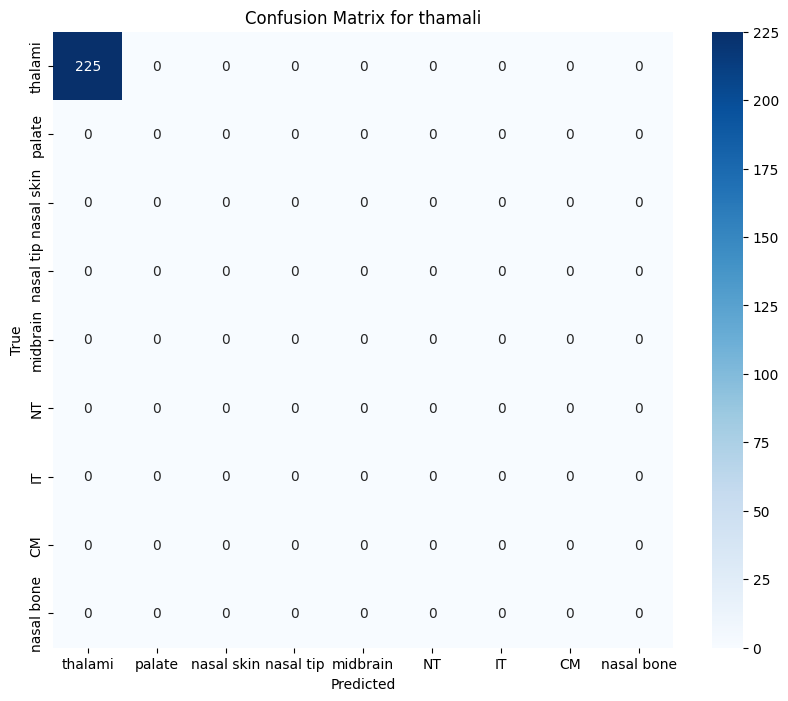

Classification Report for thamali:
              precision    recall  f1-score   support

     thalami       1.00      1.00      1.00       225
      palate       0.00      0.00      0.00         0
  nasal skin       0.00      0.00      0.00         0
   nasal tip       0.00      0.00      0.00         0
    midbrain       0.00      0.00      0.00         0
          NT       0.00      0.00      0.00         0
          IT       0.00      0.00      0.00         0
          CM       0.00      0.00      0.00         0
  nasal bone       0.00      0.00      0.00         0

    accuracy                           1.00       225
   macro avg       0.11      0.11      0.11       225
weighted avg       1.00      1.00      1.00       225


--- Training and Evaluating for palate ---
Epoch 1/1
 Train Loss: 1.1936 | Train Acc: 78.03%
 Val Loss:   1.2288 | Val Acc:   92.75%

--- Evaluation for palate ---


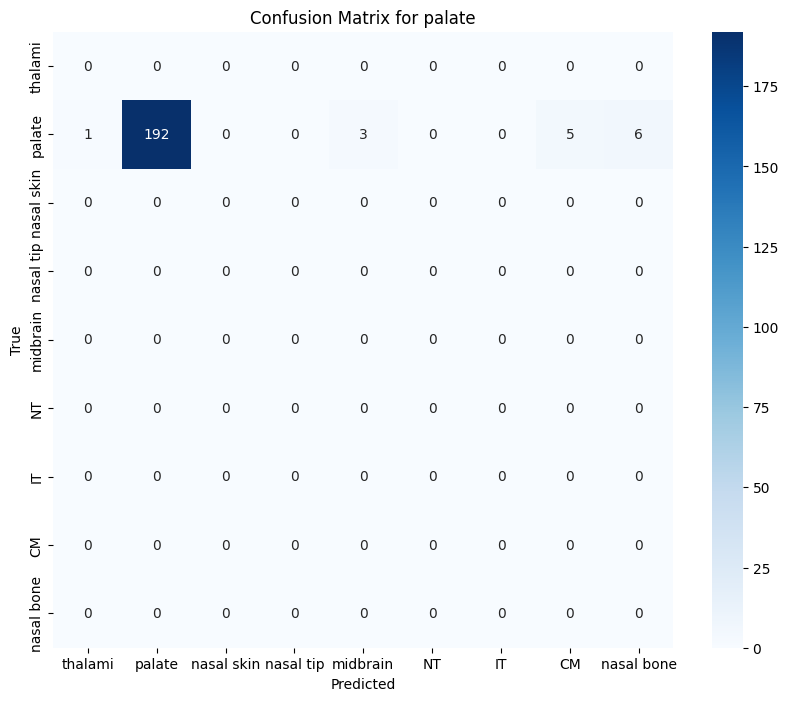

Classification Report for palate:
              precision    recall  f1-score   support

     thalami       0.00      0.00      0.00         0
      palate       1.00      0.93      0.96       207
  nasal skin       0.00      0.00      0.00         0
   nasal tip       0.00      0.00      0.00         0
    midbrain       0.00      0.00      0.00         0
          NT       0.00      0.00      0.00         0
          IT       0.00      0.00      0.00         0
          CM       0.00      0.00      0.00         0
  nasal bone       0.00      0.00      0.00         0

    accuracy                           0.93       207
   macro avg       0.11      0.10      0.11       207
weighted avg       1.00      0.93      0.96       207


--- Training and Evaluating for nasal_skin ---
Epoch 1/1
 Train Loss: 1.5785 | Train Acc: 59.82%
 Val Loss:   2.2057 | Val Acc:   28.57%

--- Evaluation for nasal_skin ---


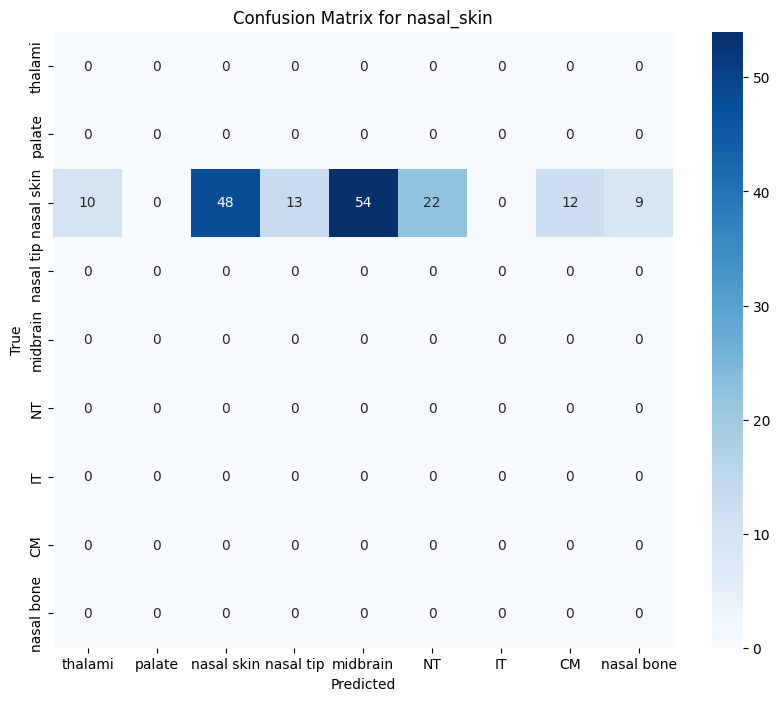

Classification Report for nasal_skin:
              precision    recall  f1-score   support

     thalami       0.00      0.00      0.00         0
      palate       0.00      0.00      0.00         0
  nasal skin       1.00      0.29      0.44       168
   nasal tip       0.00      0.00      0.00         0
    midbrain       0.00      0.00      0.00         0
          NT       0.00      0.00      0.00         0
          IT       0.00      0.00      0.00         0
          CM       0.00      0.00      0.00         0
  nasal bone       0.00      0.00      0.00         0

    accuracy                           0.29       168
   macro avg       0.11      0.03      0.05       168
weighted avg       1.00      0.29      0.44       168


--- Training and Evaluating for nasal_tip ---
Epoch 1/1
 Train Loss: 1.2959 | Train Acc: 71.30%
 Val Loss:   2.0651 | Val Acc:   28.79%

--- Evaluation for nasal_tip ---


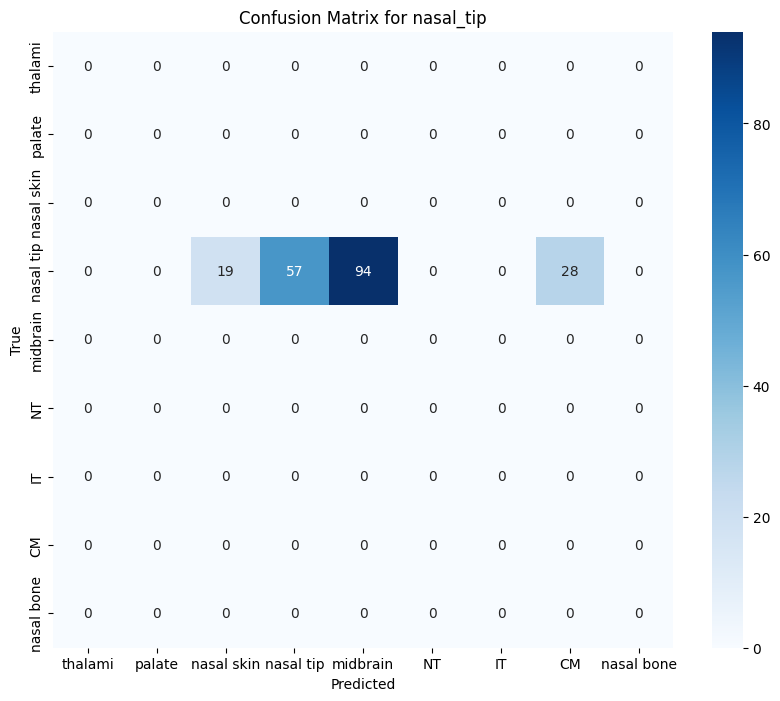

Classification Report for nasal_tip:
              precision    recall  f1-score   support

     thalami       0.00      0.00      0.00         0
      palate       0.00      0.00      0.00         0
  nasal skin       0.00      0.00      0.00         0
   nasal tip       1.00      0.29      0.45       198
    midbrain       0.00      0.00      0.00         0
          NT       0.00      0.00      0.00         0
          IT       0.00      0.00      0.00         0
          CM       0.00      0.00      0.00         0
  nasal bone       0.00      0.00      0.00         0

    accuracy                           0.29       198
   macro avg       0.11      0.03      0.05       198
weighted avg       1.00      0.29      0.45       198


--- Training and Evaluating for midbrain ---
Epoch 1/1
 Train Loss: 1.2552 | Train Acc: 73.52%
 Val Loss:   1.0094 | Val Acc:   93.75%

--- Evaluation for midbrain ---


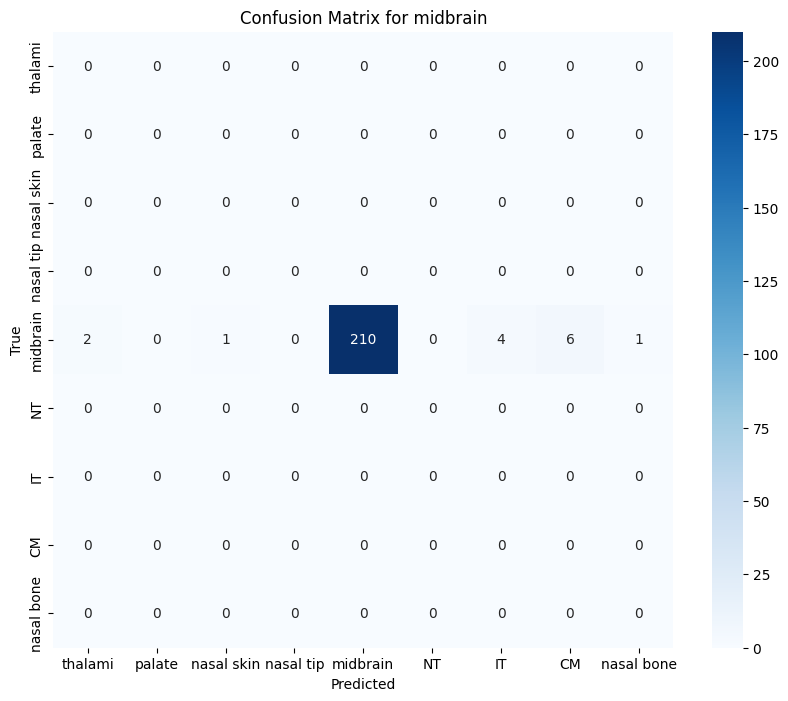

Classification Report for midbrain:
              precision    recall  f1-score   support

     thalami       0.00      0.00      0.00         0
      palate       0.00      0.00      0.00         0
  nasal skin       0.00      0.00      0.00         0
   nasal tip       0.00      0.00      0.00         0
    midbrain       1.00      0.94      0.97       224
          NT       0.00      0.00      0.00         0
          IT       0.00      0.00      0.00         0
          CM       0.00      0.00      0.00         0
  nasal bone       0.00      0.00      0.00         0

    accuracy                           0.94       224
   macro avg       0.11      0.10      0.11       224
weighted avg       1.00      0.94      0.97       224


--- Training and Evaluating for nuchal_transluceny ---
Epoch 1/1
 Train Loss: 0.7130 | Train Acc: 98.09%
 Val Loss:   0.3989 | Val Acc:   100.00%

--- Evaluation for nuchal_transluceny ---


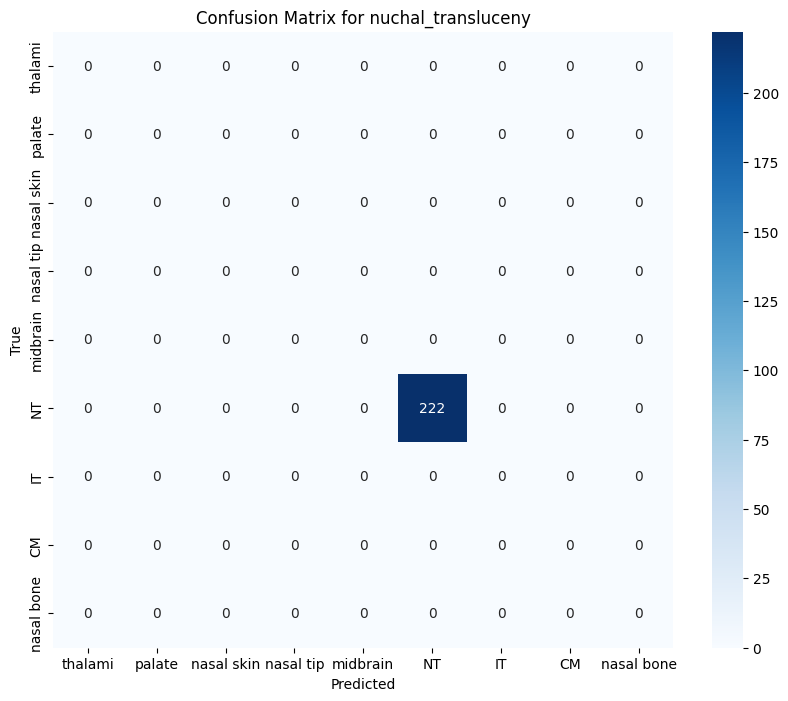

Classification Report for nuchal_transluceny:
              precision    recall  f1-score   support

     thalami       0.00      0.00      0.00         0
      palate       0.00      0.00      0.00         0
  nasal skin       0.00      0.00      0.00         0
   nasal tip       0.00      0.00      0.00         0
    midbrain       0.00      0.00      0.00         0
          NT       1.00      1.00      1.00       222
          IT       0.00      0.00      0.00         0
          CM       0.00      0.00      0.00         0
  nasal bone       0.00      0.00      0.00         0

    accuracy                           1.00       222
   macro avg       0.11      0.11      0.11       222
weighted avg       1.00      1.00      1.00       222


--- Training and Evaluating for intracranial_translucency ---
Epoch 1/1
 Train Loss: 1.2299 | Train Acc: 74.89%
 Val Loss:   1.0681 | Val Acc:   87.84%

--- Evaluation for intracranial_translucency ---


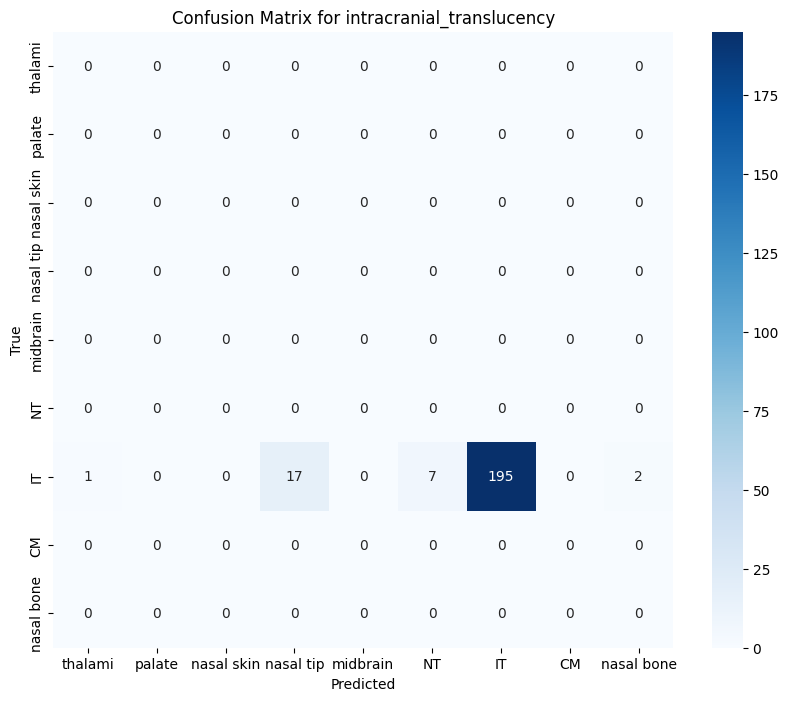

Classification Report for intracranial_translucency:
              precision    recall  f1-score   support

     thalami       0.00      0.00      0.00         0
      palate       0.00      0.00      0.00         0
  nasal skin       0.00      0.00      0.00         0
   nasal tip       0.00      0.00      0.00         0
    midbrain       0.00      0.00      0.00         0
          NT       0.00      0.00      0.00         0
          IT       1.00      0.88      0.94       222
          CM       0.00      0.00      0.00         0
  nasal bone       0.00      0.00      0.00         0

    accuracy                           0.88       222
   macro avg       0.11      0.10      0.10       222
weighted avg       1.00      0.88      0.94       222


--- Training and Evaluating for cisterna_magna ---
Epoch 1/1
 Train Loss: 1.3556 | Train Acc: 66.82%
 Val Loss:   1.4917 | Val Acc:   63.18%

--- Evaluation for cisterna_magna ---


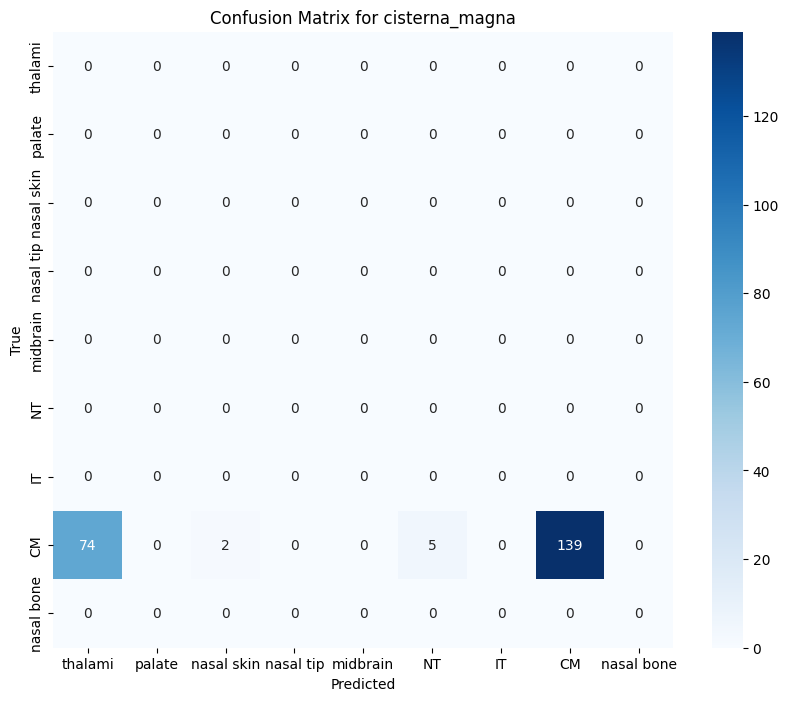

Classification Report for cisterna_magna:
              precision    recall  f1-score   support

     thalami       0.00      0.00      0.00         0
      palate       0.00      0.00      0.00         0
  nasal skin       0.00      0.00      0.00         0
   nasal tip       0.00      0.00      0.00         0
    midbrain       0.00      0.00      0.00         0
          NT       0.00      0.00      0.00         0
          IT       0.00      0.00      0.00         0
          CM       1.00      0.63      0.77       220
  nasal bone       0.00      0.00      0.00         0

    accuracy                           0.63       220
   macro avg       0.11      0.07      0.09       220
weighted avg       1.00      0.63      0.77       220



In [ ]:
EPOCHS = 1

# Create ordered list of class names for reporting
# Invert the mapping to get names by code
code_to_name = {v: k for k, v in mapping.items()}
ordered_class_names = [code_to_name[i] for i in range(number_of_structures)]

for name, structure in structures.items():
    print(f"\n--- Training and Evaluating for {name} ---")

    # Retrieve model, criterion, and optimizer specific to this structure
    model = structure["densenet"]["model"]
    criterion = structure["densenet"]["criterion"]
    optimizer = structure["densenet"]["optimizer"]

    training_loader = structure["loader"]["training"]
    validation_loader = structure["loader"]["validation"]

    if training_loader is None or validation_loader is None:
        print(f"Skipping {name}: Data loaders not initialized.")
        continue

    for epoch in range(EPOCHS):
        train_loss, train_acc = train_one_epoch(model, training_loader, criterion, optimizer)
        val_loss, val_acc = validate_one_epoch(model, validation_loader, criterion)

        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f" Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f" Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

    # --- Evaluation after training for each structure ---
    print(f"\n--- Evaluation for {name} ---")
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for imgs, labels in validation_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds.extend(outputs.argmax(1).cpu().numpy())
            trues.extend(labels.cpu().numpy())

    # Filter class names to only include the relevant class for this specific structure's output
    # The model predicts for all 9 classes, but the 'trues' will only contain one specific class label.
    # So we only want the class name corresponding to the `current_code` (which is 'thalami' for this example)
    # The problem is that the confusion matrix and classification report will try to report on all 9 classes,
    # but 'trues' and 'preds' will be mostly or entirely for one class.
    # To make the reports meaningful for a single-class training scenario, we need to adapt it.
    # For simplicity and to show the current class's performance, let's use the full class names
    # but acknowledge that most entries will be 0 for 'trues' and 'preds' if the model predicts other classes.

    # Confusion Matrix
    cm = confusion_matrix(trues, preds, labels=range(number_of_structures))
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=ordered_class_names, yticklabels=ordered_class_names, cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Classification Report
    print(f"Classification Report for {name}:")
    print(classification_report(trues, preds, target_names=ordered_class_names, labels=range(number_of_structures), zero_division=0))


In [ ]:
for name, structure in structures.items():
    if structure["training"].empty:
        print(f"{name}: Sem dados para treino. Pulando...")
        structure["weights"] = None # Handle case with no training data
        continue

    # Get the unique code for this structure from its training data.
    # Assuming each 'structure' DataFrame has only one unique 'code'.
    unique_codes_in_training = structure["training"]['code'].unique()
    if len(unique_codes_in_training) != 1:
        print(f"Error: Expected exactly one unique code for structure '{name}', but found {len(unique_codes_in_training)}: {unique_codes_in_training}")
        # For a quick fix, let's proceed with the first unique code, but note the warning.
        current_code = unique_codes_in_training[0]
    else:
        current_code = unique_codes_in_training[0]

    # Create a weight tensor of size 'number_of_structures' (which is 9)
    # Initialize all weights to 0.0
    class_weights_tensor_for_structure = torch.zeros(number_of_structures, dtype=torch.float).to(device)

    # Set the weight for the current structure's code to 1.0.
    # This aligns with the previous normalization `class_weights / class_weights.max()` effectively yielding 1.0.
    class_weights_tensor_for_structure[current_code] = 1.0

    structure["weights"] = class_weights_tensor_for_structure
    print(f"Pesos para {name}:", structure["weights"])

Pesos para thamali: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
Pesos para palate: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
Pesos para nasal_skin: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')
Pesos para nasal_tip: tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0')
Pesos para midbrain: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0')
Pesos para nuchal_transluceny: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')
Pesos para intracranial_translucency: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0')
Pesos para cisterna_magna: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0')


In [ ]:
for name, structure in structures.items():
  model = models.densenet121(weights="DEFAULT")
  model.classifier = nn.Linear(1024, number_of_structures)
  model = model.to(device)

  # Use the weights stored in the current structure's dictionary
  if structure["weights"] is not None:
      criterion = nn.CrossEntropyLoss(weight=structure["weights"])
  else:
      # If there are no specific weights (e.g., no training data), use CrossEntropyLoss without weights.
      criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

  structures[name]["densenet"] = {
    "model": model,
    "criterion": criterion,
    "optimizer": optimizer
  }

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    preds, trues = [], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds.extend(outputs.argmax(1).cpu().numpy())
        trues.extend(labels.cpu().numpy())

    acc = accuracy_score(trues, preds) * 100
    return total_loss/len(loader), acc

def validate_one_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    preds, trues = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds.extend(outputs.argmax(1).cpu().numpy())
            trues.extend(labels.cpu().numpy())
    acc = accuracy_score(trues, preds) * 100
    return total_loss/len(loader), acc


--- Training and Evaluating for thamali ---
Epoch 1/1
 Train Loss: 0.8947 | Train Acc: 88.41%
 Val Loss:   0.6489 | Val Acc:   99.56%

--- Evaluation for thamali ---


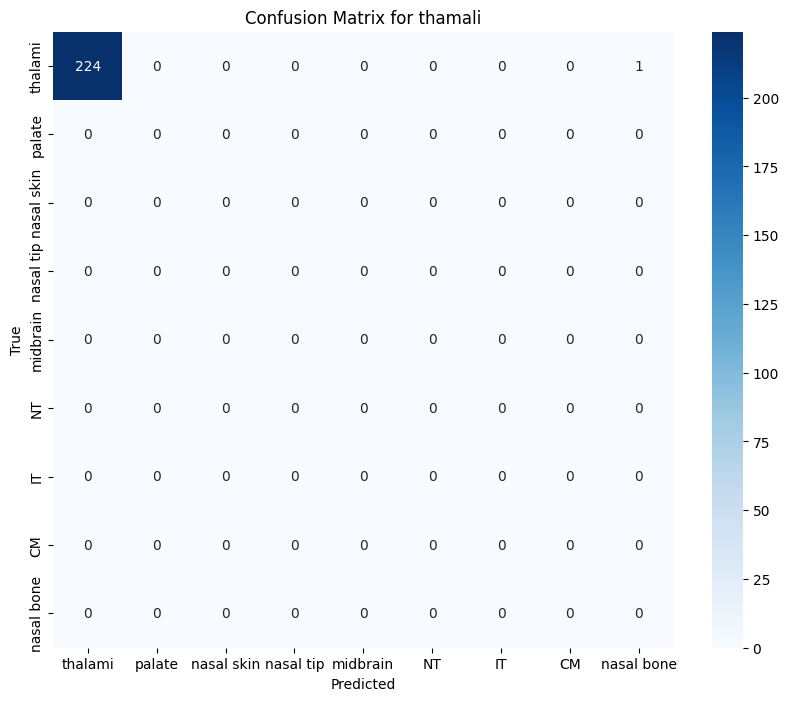

Classification Report for thamali:
              precision    recall  f1-score   support

     thalami       1.00      1.00      1.00       225
      palate       0.00      0.00      0.00         0
  nasal skin       0.00      0.00      0.00         0
   nasal tip       0.00      0.00      0.00         0
    midbrain       0.00      0.00      0.00         0
          NT       0.00      0.00      0.00         0
          IT       0.00      0.00      0.00         0
          CM       0.00      0.00      0.00         0
  nasal bone       0.00      0.00      0.00         0

    accuracy                           1.00       225
   macro avg       0.11      0.11      0.11       225
weighted avg       1.00      1.00      1.00       225


--- Training and Evaluating for palate ---
Epoch 1/1
 Train Loss: 1.3520 | Train Acc: 71.24%
 Val Loss:   1.2858 | Val Acc:   89.86%

--- Evaluation for palate ---


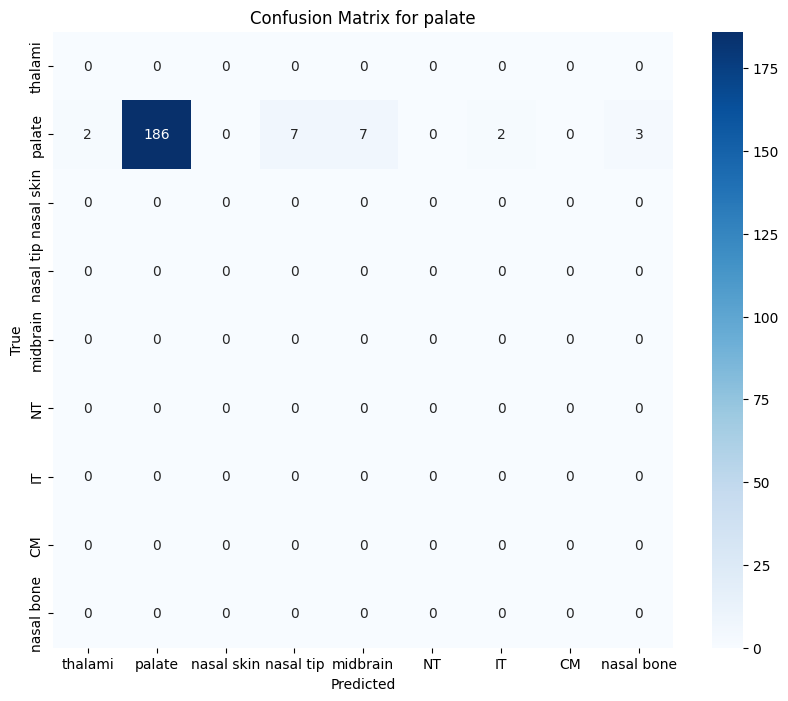

Classification Report for palate:
              precision    recall  f1-score   support

     thalami       0.00      0.00      0.00         0
      palate       1.00      0.90      0.95       207
  nasal skin       0.00      0.00      0.00         0
   nasal tip       0.00      0.00      0.00         0
    midbrain       0.00      0.00      0.00         0
          NT       0.00      0.00      0.00         0
          IT       0.00      0.00      0.00         0
          CM       0.00      0.00      0.00         0
  nasal bone       0.00      0.00      0.00         0

    accuracy                           0.90       207
   macro avg       0.11      0.10      0.11       207
weighted avg       1.00      0.90      0.95       207


--- Training and Evaluating for nasal_skin ---
Epoch 1/1
 Train Loss: 1.6208 | Train Acc: 55.95%
 Val Loss:   1.9744 | Val Acc:   25.00%

--- Evaluation for nasal_skin ---


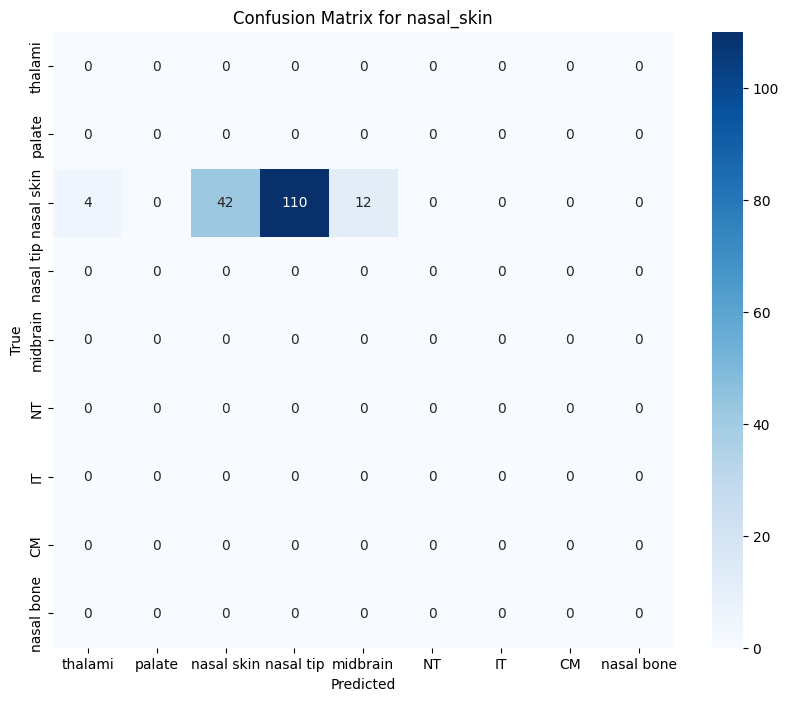

Classification Report for nasal_skin:
              precision    recall  f1-score   support

     thalami       0.00      0.00      0.00         0
      palate       0.00      0.00      0.00         0
  nasal skin       1.00      0.25      0.40       168
   nasal tip       0.00      0.00      0.00         0
    midbrain       0.00      0.00      0.00         0
          NT       0.00      0.00      0.00         0
          IT       0.00      0.00      0.00         0
          CM       0.00      0.00      0.00         0
  nasal bone       0.00      0.00      0.00         0

    accuracy                           0.25       168
   macro avg       0.11      0.03      0.04       168
weighted avg       1.00      0.25      0.40       168


--- Training and Evaluating for nasal_tip ---
Epoch 1/1
 Train Loss: 1.1455 | Train Acc: 80.28%
 Val Loss:   1.3532 | Val Acc:   82.83%

--- Evaluation for nasal_tip ---


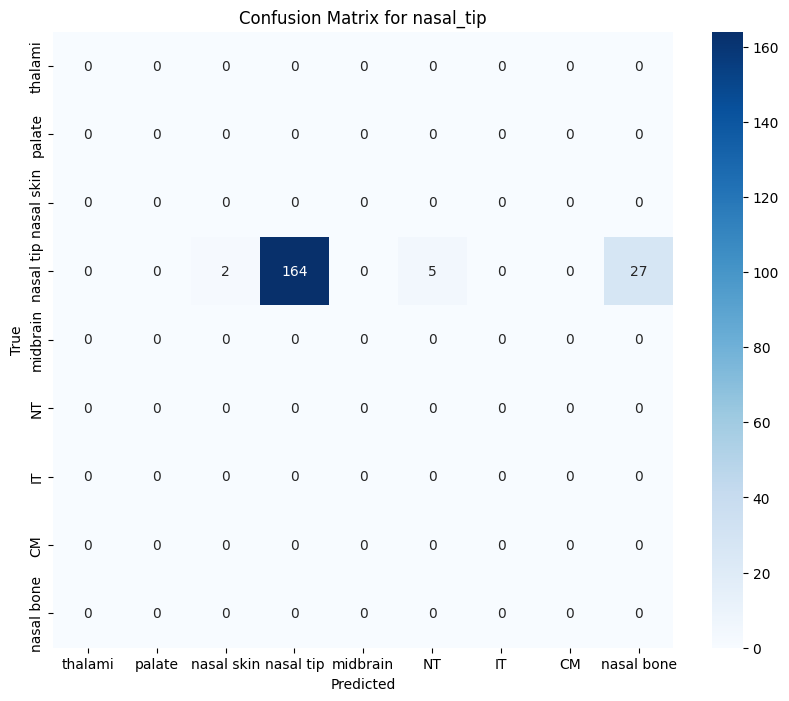

Classification Report for nasal_tip:
              precision    recall  f1-score   support

     thalami       0.00      0.00      0.00         0
      palate       0.00      0.00      0.00         0
  nasal skin       0.00      0.00      0.00         0
   nasal tip       1.00      0.83      0.91       198
    midbrain       0.00      0.00      0.00         0
          NT       0.00      0.00      0.00         0
          IT       0.00      0.00      0.00         0
          CM       0.00      0.00      0.00         0
  nasal bone       0.00      0.00      0.00         0

    accuracy                           0.83       198
   macro avg       0.11      0.09      0.10       198
weighted avg       1.00      0.83      0.91       198


--- Training and Evaluating for midbrain ---
Epoch 1/1
 Train Loss: 1.1075 | Train Acc: 79.89%
 Val Loss:   0.8892 | Val Acc:   99.11%

--- Evaluation for midbrain ---


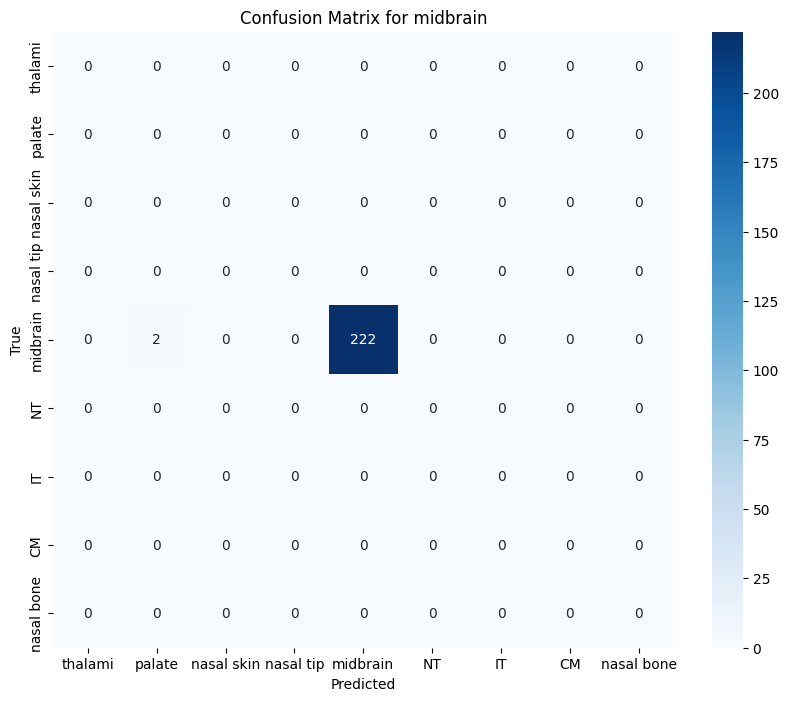

Classification Report for midbrain:
              precision    recall  f1-score   support

     thalami       0.00      0.00      0.00         0
      palate       0.00      0.00      0.00         0
  nasal skin       0.00      0.00      0.00         0
   nasal tip       0.00      0.00      0.00         0
    midbrain       1.00      0.99      1.00       224
          NT       0.00      0.00      0.00         0
          IT       0.00      0.00      0.00         0
          CM       0.00      0.00      0.00         0
  nasal bone       0.00      0.00      0.00         0

    accuracy                           0.99       224
   macro avg       0.11      0.11      0.11       224
weighted avg       1.00      0.99      1.00       224


--- Training and Evaluating for nuchal_transluceny ---
Epoch 1/1
 Train Loss: 0.5746 | Train Acc: 99.66%
 Val Loss:   0.3659 | Val Acc:   100.00%

--- Evaluation for nuchal_transluceny ---


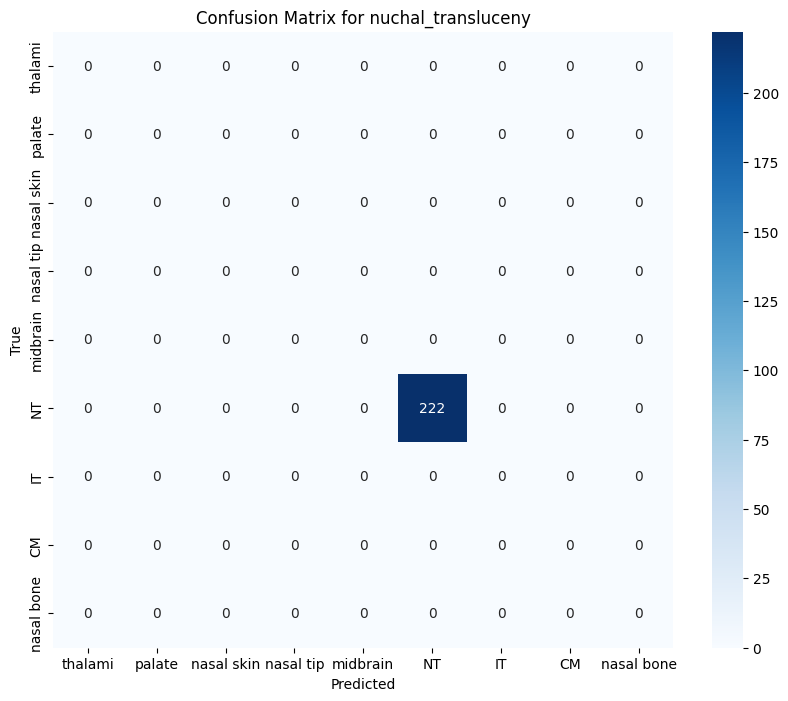

Classification Report for nuchal_transluceny:
              precision    recall  f1-score   support

     thalami       0.00      0.00      0.00         0
      palate       0.00      0.00      0.00         0
  nasal skin       0.00      0.00      0.00         0
   nasal tip       0.00      0.00      0.00         0
    midbrain       0.00      0.00      0.00         0
          NT       1.00      1.00      1.00       222
          IT       0.00      0.00      0.00         0
          CM       0.00      0.00      0.00         0
  nasal bone       0.00      0.00      0.00         0

    accuracy                           1.00       222
   macro avg       0.11      0.11      0.11       222
weighted avg       1.00      1.00      1.00       222


--- Training and Evaluating for intracranial_translucency ---
Epoch 1/1
 Train Loss: 0.9478 | Train Acc: 89.86%
 Val Loss:   0.6208 | Val Acc:   100.00%

--- Evaluation for intracranial_translucency ---


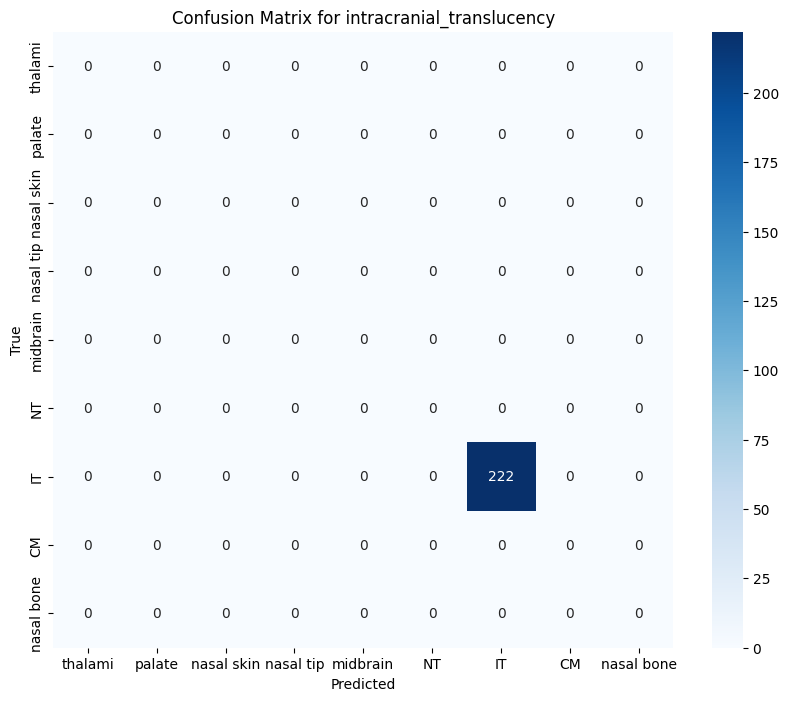

Classification Report for intracranial_translucency:
              precision    recall  f1-score   support

     thalami       0.00      0.00      0.00         0
      palate       0.00      0.00      0.00         0
  nasal skin       0.00      0.00      0.00         0
   nasal tip       0.00      0.00      0.00         0
    midbrain       0.00      0.00      0.00         0
          NT       0.00      0.00      0.00         0
          IT       1.00      1.00      1.00       222
          CM       0.00      0.00      0.00         0
  nasal bone       0.00      0.00      0.00         0

    accuracy                           1.00       222
   macro avg       0.11      0.11      0.11       222
weighted avg       1.00      1.00      1.00       222


--- Training and Evaluating for cisterna_magna ---
Epoch 1/1
 Train Loss: 0.7972 | Train Acc: 96.12%
 Val Loss:   0.6318 | Val Acc:   100.00%

--- Evaluation for cisterna_magna ---


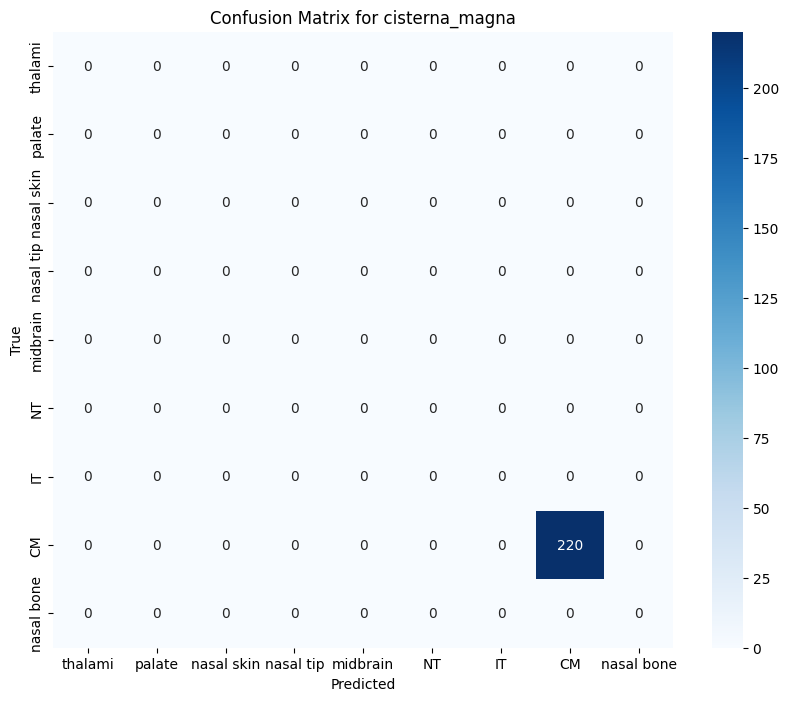

Classification Report for cisterna_magna:
              precision    recall  f1-score   support

     thalami       0.00      0.00      0.00         0
      palate       0.00      0.00      0.00         0
  nasal skin       0.00      0.00      0.00         0
   nasal tip       0.00      0.00      0.00         0
    midbrain       0.00      0.00      0.00         0
          NT       0.00      0.00      0.00         0
          IT       0.00      0.00      0.00         0
          CM       1.00      1.00      1.00       220
  nasal bone       0.00      0.00      0.00         0

    accuracy                           1.00       220
   macro avg       0.11      0.11      0.11       220
weighted avg       1.00      1.00      1.00       220



In [ ]:
EPOCHS = 1

# Create ordered list of class names for reporting
# Invert the mapping to get names by code
code_to_name = {v: k for k, v in mapping.items()}
ordered_class_names = [code_to_name[i] for i in range(number_of_structures)]

for name, structure in structures.items():
    print(f"\n--- Training and Evaluating for {name} ---")

    # Retrieve model, criterion, and optimizer specific to this structure
    model = structure["densenet"]["model"]
    criterion = structure["densenet"]["criterion"]
    optimizer = structure["densenet"]["optimizer"]

    training_loader = structure["loader"]["training"]
    validation_loader = structure["loader"]["validation"]

    if training_loader is None or validation_loader is None:
        print(f"Skipping {name}: Data loaders not initialized.")
        continue

    for epoch in range(EPOCHS):
        train_loss, train_acc = train_one_epoch(model, training_loader, criterion, optimizer)
        val_loss, val_acc = validate_one_epoch(model, validation_loader, criterion)

        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f" Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f" Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

    # --- Evaluation after training for each structure ---
    print(f"\n--- Evaluation for {name} ---")
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for imgs, labels in validation_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds.extend(outputs.argmax(1).cpu().numpy())
            trues.extend(labels.cpu().numpy())

    # Filter class names to only include the relevant class for this specific structure's output
    # The model predicts for all 9 classes, but the 'trues' will only contain one specific class label.
    # So we only want the class name corresponding to the `current_code` (which is 'thalami' for this example)
    # The problem is that the confusion matrix and classification report will try to report on all 9 classes,
    # but 'trues' and 'preds' will be mostly or entirely for one class.
    # To make the reports meaningful for a single-class training scenario, we need to adapt it.
    # For simplicity and to show the current class's performance, let's use the full class names
    # but acknowledge that most entries will be 0 for 'trues' and 'preds' if the model predicts other classes.

    # Confusion Matrix
    cm = confusion_matrix(trues, preds, labels=range(number_of_structures))
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=ordered_class_names, yticklabels=ordered_class_names, cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Classification Report
    print(f"Classification Report for {name}:")
    print(classification_report(trues, preds, target_names=ordered_class_names, labels=range(number_of_structures), zero_division=0))


In [ ]:
# This cell's content has been moved and integrated into cell Ntq7vSKnC46a for per-structure evaluation. Clearing it to avoid redundancy or errors.

In [ ]:
# This cell is currently using undefined variables (e.g., `val_df`, `le`).
# It also seems to be a general test prediction script.
# For now, I will clear this cell as the immediate request is to continue training and evaluating the individual models.
# If a separate, general test prediction is required later, it can be re-addressed with correct data and label mappings.

In [ ]:
for name, structure in structures.items():
    if structure["training"].empty:
        print(f"{name}: Sem dados para treino. Pulando...")
        structure["weights"] = None # Handle case with no training data
        continue

    # Get the unique code for this structure from its training data.
    # Assuming each 'structure' DataFrame has only one unique 'code'.
    unique_codes_in_training = structure["training"]['code'].unique()
    if len(unique_codes_in_training) != 1:
        print(f"Error: Expected exactly one unique code for structure '{name}', but found {len(unique_codes_in_training)}: {unique_codes_in_training}")
        # For a quick fix, let's proceed with the first unique code, but note the warning.
        current_code = unique_codes_in_training[0]
    else:
        current_code = unique_codes_in_training[0]

    # Create a weight tensor of size 'number_of_structures' (which is 9)
    # Initialize all weights to 0.0
    class_weights_tensor_for_structure = torch.zeros(number_of_structures, dtype=torch.float).to(device)

    # Set the weight for the current structure's code to 1.0.
    # This aligns with the previous normalization `class_weights / class_weights.max()` effectively yielding 1.0.
    class_weights_tensor_for_structure[current_code] = 1.0

    structure["weights"] = class_weights_tensor_for_structure
    print(f"Pesos para {name}:", structure["weights"])

Pesos para thamali: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
Pesos para palate: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
Pesos para nasal_skin: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')
Pesos para nasal_tip: tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0')
Pesos para midbrain: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0')
Pesos para nuchal_transluceny: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')
Pesos para intracranial_translucency: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0')
Pesos para cisterna_magna: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0')


In [ ]:
for name, structure in structures.items():
  model = models.densenet121(weights="DEFAULT")
  model.classifier = nn.Linear(1024, number_of_structures)
  model = model.to(device)

  # Use the weights stored in the current structure's dictionary
  if structure["weights"] is not None:
      criterion = nn.CrossEntropyLoss(weight=structure["weights"])
  else:
      # If there are no specific weights (e.g., no training data), use CrossEntropyLoss without weights.
      criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

  structures[name]["densenet"] = {
    "model": model,
    "criterion": criterion,
    "optimizer": optimizer
  }

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    preds, trues = [], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds.extend(outputs.argmax(1).cpu().numpy())
        trues.extend(labels.cpu().numpy())

    acc = accuracy_score(trues, preds) * 100
    return total_loss/len(loader), acc

def validate_one_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    preds, trues = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds.extend(outputs.argmax(1).cpu().numpy())
            trues.extend(labels.cpu().numpy())
    acc = accuracy_score(trues, preds) * 100
    return total_loss/len(loader), acc


--- Training and Evaluating for thamali ---
Epoch 1/1
 Train Loss: 0.9258 | Train Acc: 85.95%
 Val Loss:   0.8371 | Val Acc:   98.22%

--- Evaluation for thamali ---


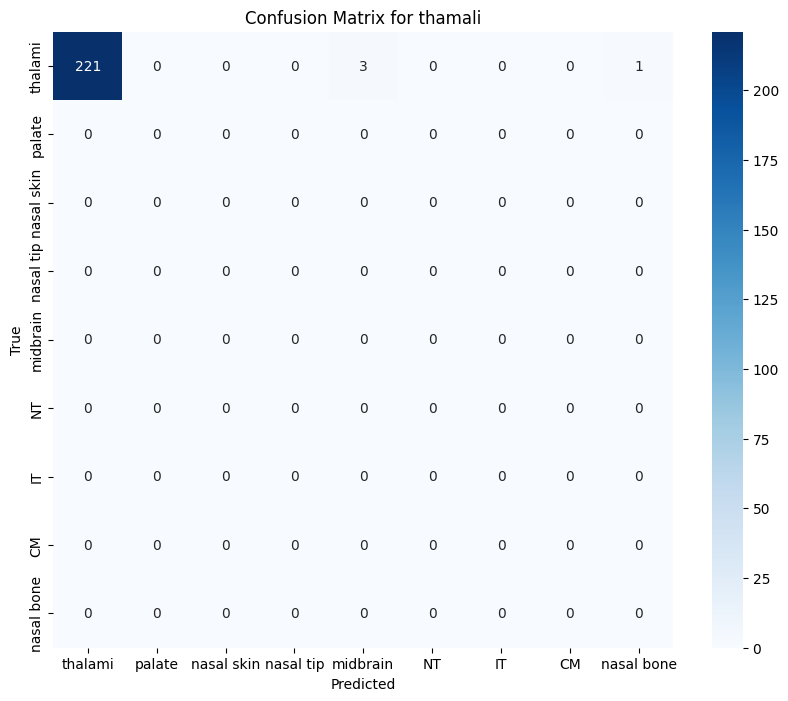

Classification Report for thamali:
              precision    recall  f1-score   support

     thalami       1.00      0.98      0.99       225
      palate       0.00      0.00      0.00         0
  nasal skin       0.00      0.00      0.00         0
   nasal tip       0.00      0.00      0.00         0
    midbrain       0.00      0.00      0.00         0
          NT       0.00      0.00      0.00         0
          IT       0.00      0.00      0.00         0
          CM       0.00      0.00      0.00         0
  nasal bone       0.00      0.00      0.00         0

    accuracy                           0.98       225
   macro avg       0.11      0.11      0.11       225
weighted avg       1.00      0.98      0.99       225


--- Training and Evaluating for palate ---


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c8c14e160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1618, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
    

KeyboardInterrupt: 

In [ ]:
EPOCHS = 1

# Create ordered list of class names for reporting
# Invert the mapping to get names by code
code_to_name = {v: k for k, v in mapping.items()}
ordered_class_names = [code_to_name[i] for i in range(number_of_structures)]

for name, structure in structures.items():
    print(f"\n--- Training and Evaluating for {name} ---")

    # Retrieve model, criterion, and optimizer specific to this structure
    model = structure["densenet"]["model"]
    criterion = structure["densenet"]["criterion"]
    optimizer = structure["densenet"]["optimizer"]

    training_loader = structure["loader"]["training"]
    validation_loader = structure["loader"]["validation"]

    if training_loader is None or validation_loader is None:
        print(f"Skipping {name}: Data loaders not initialized.")
        continue

    for epoch in range(EPOCHS):
        train_loss, train_acc = train_one_epoch(model, training_loader, criterion, optimizer)
        val_loss, val_acc = validate_one_epoch(model, validation_loader, criterion)

        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f" Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f" Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

    # --- Evaluation after training for each structure ---
    print(f"\n--- Evaluation for {name} ---")
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for imgs, labels in validation_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds.extend(outputs.argmax(1).cpu().numpy())
            trues.extend(labels.cpu().numpy())

    # Filter class names to only include the relevant class for this specific structure's output
    # The model predicts for all 9 classes, but the 'trues' will only contain one specific class label.
    # So we only want the class name corresponding to the `current_code` (which is 'thalami' for this example)
    # The problem is that the confusion matrix and classification report will try to report on all 9 classes,
    # but 'trues' and 'preds' will be mostly or entirely for one class.
    # To make the reports meaningful for a single-class training scenario, we need to adapt it.
    # For simplicity and to show the current class's performance, let's use the full class names
    # but acknowledge that most entries will be 0 for 'trues' and 'preds' if the model predicts other classes.

    # Confusion Matrix
    cm = confusion_matrix(trues, preds, labels=range(number_of_structures))
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=ordered_class_names, yticklabels=ordered_class_names, cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Classification Report
    print(f"Classification Report for {name}:")
    print(classification_report(trues, preds, target_names=ordered_class_names, labels=range(number_of_structures), zero_division=0))
